<a href="https://colab.research.google.com/github/Buchunwang/UK-CLI/blob/main/Replication_of_K%26N(1998).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replicate without standardization


---
(standardized version is below the code without standardization)


In [2]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kndata4.csv'
print('From URL:', url)
kalpre1 = pd.read_csv(url, header=None, encoding='utf-8')

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kndata4.csv


In [3]:
##########################################################################
#          pre-setting
##########################################################################
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings

# Remove warning message of time series from each iteration
def custom_warning_handler(*args, **kwargs):
    pass

warnings.showwarning = custom_warning_handler

##########################################################################
#          iteration setting
##########################################################################
iter = 10000 # number of iterations
burn = 2000 #we burn the first 2000 iterations and sampling from the later 8000 iterations in the Monter Carlo

##########################################################################
#          input data
##########################################################################
delta_y_mean = np.zeros((4,1))
for i in range(4):
    delta_y_mean[i,0] = np.mean(kalpre1.iloc[:, i]) #used in generating delta in appendix 7

scale= StandardScaler()
#kalpre = scale.fit_transform(kalpre1)#standardize data
kalpre=kalpre1.values
np.random.seed(198011) #fix randomness
N = kalpre.shape[0] #length of input
Y = np.transpose(kalpre[:,0:4])#Y_{1t} to Y_{4t}
# Calculate delta_y, delta_y_t-1, and delta_y_t-2
# Yit-E(Y), remove the mean value
y = np.zeros((4, N))
y1lag = np.zeros((4, N))
y2lag = np.zeros((4, N))

for i in range(4):
    y[i, :] = kalpre[:, i ].T-np.mean(kalpre[:, i ])
    y1lag[i, :] = kalpre[:, i + 4].T-np.mean(kalpre[:, i+4 ])
    y2lag[i, :] = kalpre[:, i + 8].T-np.mean(kalpre[:, i+8 ])




x = np.zeros((3, N))#empty matrix to save mean value of xi_t

##########################################################################
# input for first kalman filter
##########################################################################
var_vt=1 # iid variance in equation (3)
Q_kal = np.zeros((6,6))
Q_kal[0,0]=1 #Q in kalman filter, process noise

phi=np.zeros(2)
psi=np.zeros((4,2))


ctt=np.zeros(N) # composite index

mu_st=np.zeros(N) #regime-switching element for kalman filter
phimu_st=np.zeros(N) #regime-switching element with lags for kalman filter: phi(L)*mu_st

##########################################################################
# The following settings are for estimation of parameters after hmailton  filter
##########################################################################

#Now we begin to set the initial values of parameters wwe are going to estimate in the algorithm

# As this code is a mixture of three independent code, unavoidabely there are repeated variables
#such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop
N=kalpre.shape[0]-2
rrighta4 =np.zeros((N-5,4))
#rrighta3 = np.zeros((1, N - 2))#this matrix is for calculating distribution of lamda

X1 = np.zeros((N - 2, 2))
X2 = np.zeros((N - 2, 2))
X3 = np.zeros((N - 2, 2))
X4 = np.zeros((N - 2, 2))

Q = np.zeros((N - 4, 2))
Qstar = np.zeros((N - 4, 2))

# Initialize the DataFrame with the size of 8x419 with NaNs
inputkal1 = pd.DataFrame(np.nan, index=range(N), columns=range(7))
# Fill the columns 4 to 8 with the data from 'kalpre'
inputkal1.iloc[:,3:7] = (y[:,2:N+2]).T


mut = np.zeros(N)#corresponding regime for t=3 to N, this is for estimating parameters

fvarphi = np.array([[1, 0], [0, 1]])


##########################################################################
# user-choose prior
##########################################################################


# variance and mean prior
varlamda1p = 1
varlamda2p = 1
varlamda3p = 1
varlamda4p = np.eye(4)

meanlamda1p = 0 #lamda_1~N(meanlamda1,varlamda1)
meanlamda2p = 0
meanlamda3p = 0
meanlamda4p = np.array([[0],[0],[0],[0]])


varpsi1p = np.eye(2)
varpsi2p = np.eye(2)
varpsi3p = np.eye(2)
varpsi4p = np.eye(2)

meanpsi1p = np.zeros((2, 1))#psi_1~N(meanpsi1,varpsi1), meanpsi1=np.array([[a],[b]]),varpsii1=np.array([[a1,a2],[b1,b2]])
meanpsi2p = np.zeros((2, 1))
meanpsi3p = np.zeros((2, 1))
meanpsi4p = np.zeros((2, 1))

# for IG(a,b), a_prior is 0, and first input of posterior IG: a+N/2 is fixed,
# so we just fix it here, no need to change in every iteration
sig1a =  N / 2 #sigma_1~IG(sig1a,sig1b) inverse gamma distribution
sig2a =  N / 2
sig3a =  N / 2
sig4a =  N / 2
sig1b = 0
sig2b = 0
sig3b = 0
sig4b = 0


varphip = np.eye(2)
meanphip = np.array([[0], [0]])
varmup = np.eye(2)
meanmup = np.array([[0], [0]])



##########################################################################
# form storage space
##########################################################################
N=kalpre.shape[0]
# Output
# We set some empty matrices here to save values from each iteration
# After the 2000 burn-in period, we need to save value for later 80000 iterations
mlamda1 = np.zeros(iter-burn)
mlamda2 = np.zeros(iter-burn)
mlamda3 = np.zeros(iter-burn)
mlamda4 = np.zeros(iter-burn)
mlamda41 = np.zeros(iter-burn)
mlamda42 = np.zeros(iter-burn)
mlamda43 = np.zeros(iter-burn)
vlamda1 = np.zeros(iter-burn)
vlamda2 = np.zeros(iter-burn)
vlamda3 = np.zeros(iter-burn)
vlamda4 = np.zeros(iter-burn)
vlamda41 = np.zeros(iter-burn)
vlamda42 = np.zeros(iter-burn)
vlamda43 = np.zeros(iter-burn)
bsig1 = np.zeros(iter-burn)
bsig2 = np.zeros(iter-burn)
bsig3 = np.zeros(iter-burn)
bsig4 = np.zeros(iter-burn)

mpsi11 = np.zeros(iter-burn)
mpsi21 = np.zeros(iter-burn)
mpsi31 = np.zeros(iter-burn)
mpsi41 = np.zeros(iter-burn)
mpsi12 = np.zeros(iter-burn)
mpsi22 = np.zeros(iter-burn)
mpsi32 = np.zeros(iter-burn)
mpsi42 = np.zeros(iter-burn)

vpsi11 = np.zeros(iter-burn)
vpsi21 = np.zeros(iter-burn)
vpsi31 = np.zeros(iter-burn)
vpsi41 = np.zeros(iter-burn)
vpsi12 = np.zeros(iter-burn)
vpsi22 = np.zeros(iter-burn)
vpsi32 = np.zeros(iter-burn)
vpsi42 = np.zeros(iter-burn)

mphi1 = np.zeros(iter-burn)
mphi2 = np.zeros(iter-burn)
vphi1 = np.zeros(iter-burn)
vphi2 = np.zeros(iter-burn)
mmu1 = np.zeros(iter-burn)
mmu2 = np.zeros(iter-burn)
vmu1 = np.zeros(iter-burn)
vmu2 = np.zeros(iter-burn)
transition_prob_p=np.zeros(iter-burn)
transition_prob_q=np.zeros(iter-burn)
delta=np.zeros(iter-burn)
CCIsample=np.zeros(N)
sample_ct=np.zeros((N, 1))
regime=np.zeros((N-4, 1))








##########################################################################
# Initial input
##########################################################################
lamda1=0.5
lamda2=0.5
lamda3=0.5
lamda4=0.5
lamda41=0
lamda42=0
lamda43=0

psi=np.zeros((4,2))

sig1 = np.array([0.2])
sig2 = np.array([0.2])
sig3 = np.array([0.2])
sig4 = np.array([0.2])



phi[0]=0
phi[1]=0

mu0=-2
mu1=2.5

top_row = np.array([phi[0], phi[1], 0, 0, 0, 0])
# define the bottom part
bottom_part = np.hstack((np.eye(5), np.zeros((5, 1))))
# stack them vertically
A = np.vstack((top_row, bottom_part))

q = 0.9
p = 0.9

##################################  initial St
#St=np.zeros(N) # as we are starting from kalman filter, St for kalman filter is 421
def generate_markov_chain(p, q, initial_state, N):
    # Initialize the Markov Chain
    markov_chain = np.zeros(N)
    markov_chain[0] = initial_state


    for i in range(1, N):
        if markov_chain[i-1] == 1:
            markov_chain[i] = np.random.choice([0, 1], p=[1-p, p])
        else:
            markov_chain[i] = np.random.choice([0, 1], p=[q, 1-q])

    return markov_chain
initial_state = 0  # initial state
St = generate_markov_chain(p, q, initial_state, N)
SSt=St
mu_st = mu0 * np.ones(N) + mu1 * np.ones(N) * St

phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = np.array(phimu_st)
phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
Mu_st=np.zeros((6,N))
Mu_st[0,:]=phimu_st

new_delta_ct= np.zeros((N, 1))


##############################################################################
# initial setting finishes here
##############################################################################

In [ ]:
from scipy.stats import multivariate_normal
##############################################################################
#Start iteration here
##############################################################################

for i in range(iter):

# First part of MCMC------- Kalman Filter

##############################

    N=kalpre.shape[0]   # length of data

# Use the parameters from last iteration
# we need new A,R,H
    top_row = np.array([phi[0], phi[1], 0, 0, 0, 0])

# define the bottom part
    bottom_part = np.hstack((np.eye(5), np.zeros((5, 1))))

# stack them vertically
    A = np.vstack((top_row, bottom_part))


    R = np.array([[sig1.item(), 0, 0, 0],
              [0, sig2.item(), 0, 0],
              [ 0, 0, sig3.item(), 0],
              [ 0, 0, 0, sig4.item()]])

    H = np.array([
    [lamda1, -lamda1 * psi[0, 0], -lamda1 * psi[0, 1],0,0,0],
    [lamda2, -lamda2 * psi[1, 0], -lamda2 * psi[1, 1],0,0,0],
    [lamda3, -lamda3 * psi[2, 0], -lamda3 * psi[2, 1],0,0,0],
    [lamda4, -lamda4*psi[3,0] + lamda41, -lamda4*psi[3,1] - lamda41*psi[3,0] + lamda42, -lamda41*psi[3, 1] - lamda42*psi[3,0] + lamda43, -lamda42*psi[3,1] - lamda43*psi[3,0], -lamda43*psi[3,1]]
    ])


#all lamda and psi come from random sampling from last iteration
    H = np.squeeze(H)
    phimu_st=np.zeros(N)

    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
    Mu_st=np.zeros((6,N))
    Mu_st[0,:]=phimu_st
    P = 0.1*np.eye(6)# initial setting of variance matrix of xi_t
    x = np.zeros((6, N))#empty matrix to save mean value of xi_t
    vct = np.zeros((6, N))#empty matrix to save variance of xi_t

    z = np.ones((4, N))
# Construct delta_y* using new psi
    ystar = y.T - psi[:, 0].T* y1lag[0:4, :].T- psi[:, 1].T*y2lag[0:4, :].T
    true4D = ystar.T

#start kalman filter
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Q_kal #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
        z[:, k] = [true4D[0, k], true4D[1, k], true4D[2, k], true4D[3, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(6) - np.dot(K, H)), P)  # Kalman equation 5
        vct[0, k] = P[0, 0]  # save variance of delta_ct



###########################################################################
# add t+1 data to information set


    c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  # generate delta_c_T
    xi = np.zeros((1, N))
    V = np.zeros((1, N))
    for ii in range(N-2):  # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
        eta = c - phi[0]*x[0, N-ii-2] - phi[1]*x[0, N-ii-3] - phimu_st[N-ii-1]  # value of eta_t two lag in my model, that's why I have term -phi(2)*x(2,N-i)
        Rt = phi[0]**2*vct[0, N-ii-2]+phi[1]**2*vct[0,N-ii-3]+var_vt
        xi[0, N-ii-2] = x[0, N-ii-2] + (phi[0]*vct[0, N-ii-2]+phi[1]*vct[0,N-ii-3])*eta/Rt
    # we only use first row of the mean and variance vector
    # so I calculated the first element of each mean & variance directly
        V[0, N-ii-2] = vct[0, N-ii-2] - (phi[0]**2 * vct[0,N-ii-2]**2 + phi[1]**2 * vct[0,N-ii-3]**2) / Rt
        c = normal(xi[0, N-ii-2], np.sqrt(V[0, N-ii-2]))
    V[0, N-1] = vct[0, N-1]# V_T didn't get upgraded, it's still from step 1
    xi[0, N-1] = x[0, N-1]# xi_T didn't get upgraded, it's still from step 1

########################
# generate new delta_ct based on new mean and variance

    for iii in range(0, N):
        new_delta_ct[iii] = np.mean(normal(xi[0,iii], np.sqrt(V[0,iii]),1000)) # new delta_c_t
  #  new_delta_ct=xi[0,:] easier option for new_delta_ct




##############################################################
############# Second step of MCMC-------- Hamilton (1989) basic filter



# Use output from Kalman filter to generate regime probability then generate St
    data= new_delta_ct.flatten()
# Create date range
    date_range = pd.date_range(start='1959-09', end='1995-01', freq='M')
# Create DataFrame with date range and data
    df = pd.DataFrame({'date': date_range, 'delta_ct': data})
    df.set_index('date', inplace=True)

# Fit the model
    mod = sm.tsa.MarkovAutoregression(
        df['delta_ct'], k_regimes=2, trend="n", order=4, switching_variance=True
)
    res = mod.fit()
#MarkovAutoregression
#MarkovRegression
    # res.smoothed_marginal_probabilities[1] # recession probability
# Attention: this is time series data
# put it back to normal later



#res.smoothed_marginal_probabilities
#res_hamilton.filtered_marginal_probabilities
# standard is not fixed, for some US recession signal, standard is >0.4
    St = (res.filtered_marginal_probabilities[1] < 0.5).astype(int)
    SSt = St.reset_index(drop=True)
    SSt = np.concatenate(([1,1,1, 1], SSt))#new St
    St=SSt[2:N].reshape(-1,1)
   # St=SSt[2:N].to_numpy().reshape(-1,1)# for estimating parameters
    # SSt will be set back to St at the start of next iteration for kalman filter






###########################################################################
# etimating parameters through gibbs sampling

# St is ready, we now prepare kalpre1


########
#pay attention:
# n for code below is N-2, for code above is N, make modefication of this

# Fill the first three columns with t, t-1, t-2 data from 'new_delta_ct' from each iteration
    for iiii in range(3):
        inputkal1.iloc[:, iiii] = new_delta_ct[2 - iiii:N - iiii]  # N-2 values


    righta3 = inputkal1.iloc[:, 0].T
    N = inputkal1.shape[0]
   # As this code is a mixture of three independent code, unavoidabely there are repeated variables
   #such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop
# Section 1
# form psi(L)*delta_y
    ys1 = (inputkal1.iloc[2:N, 3].values - inputkal1.iloc[1:N-1, 3].values * psi[0, 0] - inputkal1.iloc[0:N-2, 3].values * psi[0,1]).reshape(-1, 1)
    ys2 = (inputkal1.iloc[2:N, 4].values - inputkal1.iloc[1:N-1, 4].values * psi[1, 0] - inputkal1.iloc[0:N-2, 4].values * psi[1,1]).reshape(-1, 1)
    ys3 = (inputkal1.iloc[2:N, 5].values - inputkal1.iloc[1:N-1, 5].values * psi[2, 0] - inputkal1.iloc[0:N-2, 5].values * psi[2,1]).reshape(-1, 1)
    ys4 = (inputkal1.iloc[5:N, 6].values - inputkal1.iloc[4:N-1, 6].values * psi[3, 0] - inputkal1.iloc[3:N-2, 6].values * psi[3,1]).reshape(-1, 1)

# delta C*~
    rrighta1 = (righta3[2:N].values - righta3[1:N-1].values * psi[0, 0] - righta3[0:N-2].values * psi[0,1]).reshape(-1, 1)
    rrighta2 = (righta3[2:N].values - righta3[1:N-1].values * psi[1, 0] - righta3[0:N-2].values * psi[1,1]).reshape(-1, 1)
    rrighta3 = (righta3[2:N].values - righta3[1:N-1].values * psi[2, 0] - righta3[0:N-2].values * psi[2,1]).reshape(-1, 1)
# lamda_4 has 4 lags
    for j in range(4):
        rrighta4[:,j] = (righta3[5-j:N-j].values - righta3[4-j:N-j-1].values * psi[3, 0] - righta3[3-j:N-j-2].values * psi[3,1])

# posterior distribution of lamda mean

    meanlamda1 = 1 / (rrighta1.T @ rrighta1 / sig1 + 1 / varlamda1p) * (meanlamda1p / varlamda1p + rrighta1.T @ ys1 / sig1 )
    meanlamda2 = 1 / (rrighta2.T @ rrighta2 / sig2 + 1 / varlamda2p) * (meanlamda2p / varlamda2p + rrighta2.T @ ys2 / sig2 )
    meanlamda3 = 1 / (rrighta3.T @ rrighta3 / sig3 + 1 / varlamda3p) * (meanlamda3p / varlamda3p + rrighta3.T @ ys3 / sig3 )
    meanlamda4 = np.linalg.pinv(rrighta4.T @ rrighta4 / sig4 + np.linalg.pinv(varlamda4p)) @ (np.linalg.pinv(varlamda4p)@meanlamda4p + rrighta4.T @ ys4 / sig4 )
# posterior distribution of lamda variance
    varlamda1  = 1 / (rrighta1.T @ rrighta1 / sig1 + 1 / varlamda1p)
    varlamda2  = 1 / (rrighta2.T @ rrighta2 / sig2 + 1 / varlamda2p)
    varlamda3  = 1 / (rrighta3.T @ rrighta3 / sig3 + 1 / varlamda3p)
    varlamda4  = np.linalg.pinv(rrighta4.T @ rrighta4 / sig4 + np.linalg.pinv(varlamda4p))



#generate new lamda using new mean & new variance
    lamda1 = np.random.normal(meanlamda1, np.sqrt(varlamda1)).item()
    lamda2 = np.random.normal(meanlamda2, np.sqrt(varlamda2)).item()
    lamda3 = np.random.normal(meanlamda3, np.sqrt(varlamda3)).item()


    # USE MULTIVARIATE NORMAL TO GENERATE LAMBDA4 VECTOR - ERROR 3
    vector_lamda4= np.random.multivariate_normal(meanlamda4.flatten(), varlamda4)
    lamda4=vector_lamda4[0]
    lamda41=vector_lamda4[1]
    lamda42=vector_lamda4[2]
    lamda43=vector_lamda4[3]

# Section 2
# generate new psi
# Form Z and X as shown in the algorithm overview
    Z1 = inputkal1.iloc[:, 3].values - inputkal1.iloc[:, 0].values * lamda1
    Z2 = inputkal1.iloc[:, 4].values - inputkal1.iloc[:, 0].values * lamda2
    Z3 = inputkal1.iloc[:, 5].values - inputkal1.iloc[:, 0].values * lamda3
    Z4 = (inputkal1.iloc[3:N, 6].values
          -inputkal1.iloc[3:N, 0].values * lamda4
          -inputkal1.iloc[2:N-1, 0].values * lamda41
          -inputkal1.iloc[1:N-2, 0].values * lamda42
          -inputkal1.iloc[0:N-3, 0].values * lamda43
         )
    X1 = np.column_stack((Z1[1:N - 1], Z1[:N - 2]))
    X2 = np.column_stack((Z2[1:N - 1], Z2[:N - 2]))
    X3 = np.column_stack((Z3[1:N - 1], Z3[:N - 2]))
    X4 = np.column_stack((Z4[1:N - 4], Z4[:N - 5]))

    fvarpsi1 = np.linalg.pinv(varpsi1p) + X1.T @ X1 / sig1
    fvarpsi2 = np.linalg.pinv(varpsi2p) + X2.T @ X2 / sig2
    fvarpsi3 = np.linalg.pinv(varpsi3p) + X3.T @ X3 / sig3
    fvarpsi4 = np.linalg.pinv(varpsi4p) + X4.T @ X4 / sig4


# posterior mean of psi
    meanpsi1 = np.linalg.inv(fvarpsi1) @ (np.linalg.inv(varpsi1p) @ meanpsi1p + (X1.T @ Z1[2:N]).reshape(-1, 1) / sig1 )
    meanpsi2 = np.linalg.inv(fvarpsi2) @ (np.linalg.inv(varpsi2p) @ meanpsi2p + (X2.T @ Z2[2:N]).reshape(-1, 1) / sig2 )
    meanpsi3 = np.linalg.inv(fvarpsi3) @ (np.linalg.inv(varpsi3p) @ meanpsi3p + (X3.T @ Z3[2:N]).reshape(-1, 1) / sig3 )
    meanpsi4 = np.linalg.inv(fvarpsi4) @ (np.linalg.inv(varpsi4p) @ meanpsi4p + (X4.T @ Z4[2:N]).reshape(-1, 1) / sig4 )

# postrior variance of psi
    varpsi1  = np.linalg.inv(fvarpsi1)
    varpsi2  = np.linalg.inv(fvarpsi2)
    varpsi3  = np.linalg.inv(fvarpsi3)
    varpsi4  = np.linalg.inv(fvarpsi4)

  #USE MULTIVARIATE NORMAL TO INCORPORATE THE VARIANCE MATRIX - ERROR4
   # generate new psi from last iteration
    psi[0,:]=np.random.multivariate_normal(meanpsi1.flatten(), varpsi1)
    psi[1,:]=np.random.multivariate_normal(meanpsi2.flatten(), varpsi2)
    psi[2,:]=np.random.multivariate_normal(meanpsi3.flatten(), varpsi3)
    psi[3,:]=np.random.multivariate_normal(meanpsi4.flatten(), varpsi4)


# Process of generating sigma_i, i=1,2,3,4,5

    Xx1 = X1 * psi[0,:]
    Xx2 = X2 * psi[1,:]
    Xx3 = X3 * psi[2,:]
    Xx4 = X4 * psi[3,:]

# sigma~IG(sig1a,sig1b), posterior sig1a=4+N/2 and it's fiexed
# we only needs to calculate posterior sig1b
    sig1b =  0.5*np.dot(((Z1[2:N] - Xx1[:, 0] - Xx1[:, 1]).reshape(-1, 1)).T, (Z1[2:N] - Xx1[:, 0] - Xx1[:, 1]).reshape(-1, 1))
    sig2b =  0.5*np.dot(((Z2[2:N] - Xx2[:, 0] - Xx2[:, 1]).reshape(-1, 1)).T, (Z2[2:N] - Xx2[:, 0] - Xx2[:, 1]).reshape(-1, 1))
    sig3b =  0.5*np.dot(((Z3[2:N] - Xx3[:, 0] - Xx3[:, 1]).reshape(-1, 1)).T, (Z3[2:N] - Xx3[:, 0] - Xx3[:, 1]).reshape(-1, 1))
    sig4b =  0.5*np.dot(((Z4[2:N] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1)).T, (Z4[2:N] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1))


# generate mew sigma_i with new sig_{i}b
    sig1 = 1 / np.random.gamma(sig1a, 1/sig1b)#sig_a has been set as. 4+N/2 in the prior, no need to change
    sig2 = 1 / np.random.gamma(sig2a, 1/sig2b)
    sig3 = 1 / np.random.gamma(sig3a, 1/sig3b)
    sig4 = 1 / np.random.gamma(sig4a, 1/sig4b)


#########################################################
# Section 3
# generate phi

# Form G and Q as shown in the overview of section 3
    G = inputkal1.iloc[4:N, 0] - (mut[4:N]).T
    Q[:, 0] = inputkal1.iloc[3:N-1, 0] - (mut[3:N-1]).T
    Q[:, 1] = inputkal1.iloc[2:N-2, 0] - (mut[2:N-2]).T

    fvarphi = Q.T @ Q + np.linalg.inv(varphip)
#    if np.isnan(fvarphi).any() or (np.isnan(fvarphi[0,0]*fvarphi[1,1]-fvarphi[0,1]*fvarphi[0,1])):
#      fvarphi = np.array([[1,0],[0,1]])
# calculate posterior mean of phi
    meanphi = np.linalg.inv(fvarphi) @ (np.linalg.inv(varphip) @ meanphip + (Q.T @ G).reshape(-1, 1))
# calculate posterior variance of phi
    varphi  = np.linalg.inv(fvarphi)

    if np.isnan(varphi).any() or np.isnan(meanphi).any():
       varphi = np.array([[1,0],[0,1]])
       meanphi = np.array([[0],[0]])


    # USE MULTIVARIATE NORMAL TO SIMULATE - ERROR5
# sampling new phi
    phi=np.random.multivariate_normal(meanphi.flatten(), varphi)
#    for m in range(2):
#        phi[m]=np.random.normal(meanphi[m], np.sqrt(varphi[m, m])).item()
#    phi = generate_phi(meanphi, varphi)

    counter=0
    while abs(1-sum(phi))<0.1 and counter < 100:
      phi=np.random.multivariate_normal(meanphi.flatten(), varphi)


      counter += 1


# generating mu
# form G* and Q* as shown in the overview of section 3
    Gstar = inputkal1.iloc[4:N, 0].values.reshape(-1, 1) - phi[0]* inputkal1.iloc[3:N - 1, 0].values.reshape(-1, 1) - phi[1] * inputkal1.iloc[2:N - 2, 0].values.reshape(-1, 1)
    Qstar = np.zeros((N - 4, 2))
    Qstar[:, 0] = np.ones(N-4)
    Qstar[:, 1] = (St[4:N].flatten()
                   - phi[0]* St[3:N - 1].flatten()
                   - phi[1] * St[2:N - 2].flatten()).reshape(-1,)





#   fvarmu=np.array([[np.linalg.inv(varmu)[0,0],0],[0,np.linalg.inv(varmu)[1,1]]])
# generate posterior mean value of mu
#    fvarmu=np.array([[np.linalg.inv(varmu)[0,0],0],[0,np.linalg.inv(varmu)[1,1]]])
    meanmu = np.linalg.inv(np.linalg.inv(varmup) + Qstar.T @ Qstar) @ (np.linalg.inv(varmup) @ meanmup  + Qstar.T @ Gstar)

# generate posterior variance of mu
    varmu  = np.linalg.inv(np.linalg.inv(varmup) + Qstar.T @ Qstar)

# attention, this distribution for mu_o* and mu_1, so we need to calculate mu_0
# mu_0*=mu_0(1-phi1-phi2)
    # USE MULTIVARIATE NORMAL TO SIMULATE - ERROR6
    mu=np.random.multivariate_normal(meanmu.flatten(), varmu)
    mu0=(mu[0]/(1 -np.sum(phi)))
    mu1=mu[1]
#    mu0=(np.random.normal(meanmu[0], np.sqrt(varmu[0, 0]))/(1 -np.sum(phi))).item()
#    mu1=(np.random.normal(meanmu[1], np.sqrt(varmu[1, 1]))).item()

    counter=0
    while mu1 <= 0 and counter < 100:
      mu=np.random.multivariate_normal(meanmu.flatten(), varmu)
      mu0=(mu[0]/(1 -np.sum(phi)))
      mu1=mu[1]

      counter += 1
    if mu1 <= 0:
      mu1 = 0.5

    mut =( mu0 * np.ones(N)
        + mu1 * np.ones(N) * St.flatten().flatten()
    )




########################################################################
# main part of gibbs sampling iteration finishes here
########################################################################


########################################################################
#    To check if there is anything wrong in the iteration
    if i % 100 == 0:  # if the remainder of i divided by 100 is 0, it means i is a multiple of 100
      print(1-res.params[1],res.params[0], mu1,mu0,lamda1 )
########################################################################




########################################################################
########################################################################
# generate delta
# run kalman filter based on equation 10 and 11 in K&N (1998) to calculate delta
# replace by a kalman filter function funstion
    N=kalpre.shape[0]



    A = np.block([[phi[0], phi[1], 0, 0, *np.zeros(8)],
              [1, 0, 0, 0, *np.zeros(8)],
              [0, 1, 0, 0, *np.zeros(8)],
              [0, 0, 1, 0, *np.zeros(8)],
              [*np.zeros(4), psi[0,0], psi[0,1], *np.zeros(6)],
              [*np.zeros(4), 1, *np.zeros(7)],
              [*np.zeros(6), psi[1,0], psi[1,1], *np.zeros(4)],
              [*np.zeros(6), 1, *np.zeros(5)],
              [*np.zeros(8), psi[2,0], psi[2,1], *np.zeros(2)],
              [*np.zeros(8), 1, *np.zeros(3)],
              [*np.zeros(10), psi[3,0], psi[3,1]],
              [*np.zeros(10), 1, *np.zeros(1)]])

    H = np.block([[lamda1, *np.zeros(3), 1, *np.zeros(7)],
              [lamda2, *np.zeros(5), 1, *np.zeros(5)],
              [lamda3, *np.zeros(7), 1, *np.zeros(3)],
              [lamda4, lamda41, lamda42, lamda43, *np.zeros(6), 1, *np.zeros(1)]])

    Qdelta = np.zeros((12, 12))
    Qdelta[0, 0] = var_vt
    Qdelta[4, 4] = sig1
    Qdelta[6, 6] = sig2
    Qdelta[8, 8] = sig3
    Qdelta[10, 10] = sig4

    H = np.squeeze(H)
    P = 0.1 * np.eye(12)# initial setting of variance matrix of xi_t
    z = np.ones((4, N))
    true4D = Y
#form new mu_st
    St=SSt
    mu_st = (mu0 * np.ones(N) + mu1 * np.ones(N) * St)
    x=np.zeros((12,N))
    phimu_st=np.zeros(N)

    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])

    Mu_st=np.zeros((12,N))
    Mu_st[0,:]=phimu_st
    R=np.zeros((4,4))
    for j in range (3):
        x[:,j] = np.vstack(((mu0+mu1*((1-p)/(2-p-q)))*np.ones((4,1)), np.zeros((8,1)))).flatten()


    # Kronecker product of AAA with itself, resulting in a 144x144 matrix
    A_kron = np.kron(A, A)

# Compute the inverse of the resulting matrix
    inverse_matrix = np.linalg.inv(np.eye(144) - A_kron)

# Vectorize QQ matrix in column-major order (Fortran-style)
    Q_flat = Qdelta.flatten('F')

# Multiply the inverse matrix by the vectorized QQ
    t_vr = inverse_matrix @ Q_flat

# Reshape the result to a 12x12 matrix
    p_vr = t_vr.reshape((12, 12), order='F')
    P=p_vr
    true4D=kalpre[:,0:4].T
#start kalman filter
    k = 0
    for t in range(2,N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Qdelta #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        Hh=np.dot(H, np.dot(P, H.T)) + R
        K = np.dot(P, np.dot(H.T, np.linalg.inv(Hh)))  # Kalman equation 3
        z[:, k] = [true4D[0, k], true4D[1, k], true4D[2, k], true4D[3, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(12) - np.dot(K, H)), P)  # Kalman equation 5
##############from above, we get steady-state Kalman Gain: K
    newdelta=(np.linalg.inv(np.eye(12)-(np.eye(12) - K @ H)@A) @ K  @ delta_y_mean)[0,0]












# same value of each iteration after first 2000 iterations
    if i>burn-1:

#########################################################################

#      p_00 = res.params[0]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
#      p_11 = 1-res.params[1]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
#.     generated by Markov switching package in paython, no need to calculate by ourselves
      # delta


      mlamda1[i - burn] = meanlamda1
      mlamda2[i - burn] = meanlamda2
      mlamda3[i - burn] = meanlamda3
      mlamda4[i - burn] = meanlamda4[0]
      mlamda41[i - burn] = meanlamda4[1]
      mlamda42[i - burn] = meanlamda4[2]
      mlamda43[i - burn] = meanlamda4[3]
      vlamda1[i - burn] = varlamda1
      vlamda2[i - burn] = varlamda2
      vlamda3[i - burn] = varlamda3
      vlamda4[i - burn] = varlamda4[0,0]
      vlamda41[i - burn] = varlamda4[1,1]
      vlamda42[i - burn] = varlamda4[2,2]
      vlamda43[i - burn] = varlamda4[3,3]
      bsig1[i - burn] = sig1
      bsig2[i - burn] = sig2
      bsig2[i - burn] = sig2
      bsig3[i - burn] = sig3
      bsig4[i - burn] = sig4
      mpsi11[i - burn] = meanpsi1[0, 0]
      mpsi21[i - burn] = meanpsi2[0, 0]
      mpsi31[i - burn] = meanpsi3[0, 0]
      mpsi41[i - burn] = meanpsi4[0, 0]
      mpsi12[i - burn] = meanpsi1[1, 0]
      mpsi22[i - burn] = meanpsi2[1, 0]
      mpsi32[i - burn] = meanpsi3[1, 0]
      mpsi42[i - burn] = meanpsi4[1, 0]
      vpsi11[i - burn] = varpsi1[0, 0]
      vpsi21[i - burn] = varpsi2[0, 0]
      vpsi31[i - burn] = varpsi3[0, 0]
      vpsi41[i - burn] = varpsi4[0, 0]
      vpsi12[i - burn] = varpsi1[1, 1]
      vpsi22[i - burn] = varpsi2[1, 1]
      vpsi32[i - burn] = varpsi3[1, 1]
      vpsi42[i - burn] = varpsi4[1, 1]
      mphi1[i - burn] = meanphi[0, 0]
      mphi2[i - burn] = meanphi[1, 0]
      vphi1[i - burn] = varphi[0, 0]
      vphi2[i - burn] = varphi[1, 1]
      mmu1[i - burn] = meanmu[0, 0]/(1-sum(phi))
      mmu2[i - burn] = meanmu[1, 0]
      vmu1[i - burn] = varmu[0, 0]
      vmu2[i - burn] = varmu[1, 1]
      transition_prob_p[i-burn]=res.params[0]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      transition_prob_q[i-burn]=1-res.params[1]  #### this is q: recession to recession P(S_t=0|S_t-1=0)
      delta[i-burn]=newdelta
      sample_ct=sample_ct+new_delta_ct
      regime=regime+res.smoothed_marginal_probabilities[1].values.reshape(-1, 1)#will calculate mean value later


0.8246787688486898 0.5946446858879508 0.13860047002111583 -0.2578828973934035 0.6924158253724729


In [ ]:
import numpy as np
# after getting mean and variance from 8000 iterations, we take mean of 8000 iterations of mean value and variance value
mmlamda1 = np.mean(mlamda1)
mmlamda2 = np.mean(mlamda2)
mmlamda3 = np.mean(mlamda3)
mmlamda4 = np.mean(mlamda4)
mmlamda41 = np.mean(mlamda41)
mmlamda42 = np.mean(mlamda42)
mmlamda43 = np.mean(mlamda43)
vvlamda1 = np.mean(vlamda1)
vvlamda2 = np.mean(vlamda2)
vvlamda3 = np.mean(vlamda3)
vvlamda4 = np.mean(vlamda4)
vvlamda41 = np.mean(vlamda41)
vvlamda42 = np.mean(vlamda42)
vvlamda43 = np.mean(vlamda43)
mbsig1 = np.mean(bsig1)
mbsig2 = np.mean(bsig2)
mbsig3 = np.mean(bsig3)
mbsig4 = np.mean(bsig4)
mmpsi11 = np.mean(mpsi11)
mmpsi21 = np.mean(mpsi21)
mmpsi31 = np.mean(mpsi31)
mmpsi41 = np.mean(mpsi41)
mmpsi12 = np.mean(mpsi12)
mmpsi22 = np.mean(mpsi22)
mmpsi32 = np.mean(mpsi32)
mmpsi42 = np.mean(mpsi42)
vvpsi11 = np.mean(vpsi11)
vvpsi21 = np.mean(vpsi21)
vvpsi31 = np.mean(vpsi31)
vvpsi41 = np.mean(vpsi41)
vvpsi12 = np.mean(vpsi12)
vvpsi22 = np.mean(vpsi22)
vvpsi32 = np.mean(vpsi32)
vvpsi42 = np.mean(vpsi42)
mmphi1 = np.mean(mphi1)
mmphi2 = np.mean(mphi2)
vvphi1 = np.mean(vphi1)
vvphi2 = np.mean(vphi2)
mmmu1 = np.mean(mmu1)
mmmu2 = np.mean(mmu2)
vvmu1 = np.var(vmu1)# mmu1 saves the samples of mu1, mu1 is generated by Monte Carlo, variance would be sampled
                     # from mu0
vvmu2 = np.mean(vmu2)
sqrt_var_bsig1 = np.sqrt(np.var(bsig1))
sqrt_var_bsig2 = np.sqrt(np.var(bsig2))
sqrt_var_bsig3 = np.sqrt(np.var(bsig3))
sqrt_var_bsig4 = np.sqrt(np.var(bsig4))

#sigma is slightly special as it follows inverse Gamma distribution
#but Kim & Nelson (1998) still provides the mean and SD for sigma
# so what we do here is to calculate mean and variance of 80000 sigma_i for i=1,2,3,4,5 from 8000 iterations
mbsig1=np.mean(bsig1)
mbsig2=np.mean(bsig2)
mbsig3=np.mean(bsig3)
mbsig4=np.mean(bsig4)




# transition probabilities p & q

meanp=np.mean(transition_prob_p)
meanq=np.mean(transition_prob_q)
varp=np.var(transition_prob_p)
varq=np.var(transition_prob_q)


#regime
regime=regime/(iter-burn)

#print all results
print("mean of lamda1:", mmlamda1)
print("mean of lamda2:", mmlamda2)
print("mean of lamda3:", mmlamda3)
print("mean of lamda4:", mmlamda4)
print("mean of lamda41:", mmlamda41)
print("mean of lamda42:", mmlamda42)
print("mean of lamda43:", mmlamda43)
print("stanard deviation of lamda1:", np.sqrt(vvlamda1))
print("stanard deviation of lamda2:", np.sqrt(vvlamda2))
print("stanard deviation of lamda3:", np.sqrt(vvlamda3))
print("stanard deviation of lamda4:", np.sqrt(vvlamda4))
print("stanard deviation of lamda41:", np.sqrt(vvlamda41))
print("stanard deviation of lamda42:", np.sqrt(vvlamda42))
print("stanard deviation of lamda43:", np.sqrt(vvlamda43))
print("mean of psi11:", mmpsi11)
print("mean of psi21:", mmpsi21)
print("mean of psi31:", mmpsi31)
print("mean of psi41:", mmpsi41)
print("mean of psi12:", mmpsi12)
print("mean of psi22:", mmpsi22)
print("mean of psi32:", mmpsi32)
print("mean of psi42:", mmpsi42)
print("stanard deviation of psi11:", np.sqrt(vvpsi11))
print("stanard deviation of psi21:", np.sqrt(vvpsi21))
print("stanard deviation of psi31:", np.sqrt(vvpsi31))
print("stanard deviation of psi41:", np.sqrt(vvpsi41))
print("stanard deviation of psi12:", np.sqrt(vvpsi12))
print("stanard deviation of psi22:", np.sqrt(vvpsi22))
print("stanard deviation of psi32:", np.sqrt(vvpsi32))
print("stanard deviation of psi42:", np.sqrt(vvpsi42))
print("mean of phi1:", mmphi1)
print("mean of phi2:", mmphi2)
print("stanard deviation of phi1:", np.sqrt(vvphi1))
print("stanard deviation of phi2:", np.sqrt(vvphi2))
print("mean of mu1:", mmmu1)
print("mean of mu2:", mmmu2)
print("stanard deviation of mu1:", np.sqrt(vvmu1))
print("stanard deviation of mu2:", np.sqrt(vvmu2))
print("stanard deviation of sigma1:", sqrt_var_bsig1)
print("stanard deviation of sigma2:", sqrt_var_bsig2)
print("stanard deviation of sigma3:", sqrt_var_bsig3)
print("stanard deviation of sigma4:", sqrt_var_bsig4)
print("mean of sigma1:", mbsig1)
print("mean of sigma2:", mbsig2)
print("mean of sigma3:", mbsig3)
print("mean of sigma4:", mbsig4)
print("mean of p:", meanp)
print("var of p:", varp)
print("mean of q:", meanq)
print("var of q:", varq)
print("mean of delta:", np.mean(delta))
print("var of delta:", np.var(delta))

In [ ]:
################################################################
####### plot of recession probability
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a new DataFrame to store the ratios
date_range_ratios = pd.date_range(start='1960-01', end='1995-01', freq='M')
df_ratios = pd.DataFrame({'date': date_range_ratios, 'ratio': res.filtered_marginal_probabilities[0].ravel()})
df_ratios.set_index('date', inplace=True)

# Plot the ratio series
df_ratios['ratio'].plot(title="Recession", figsize=(20, 3))
plt.ylim(0, 1)
plt.show()

In [ ]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
ddelta=np.mean(delta)
C0=40
newCLI = np.zeros((N, 1))
dddelta=np.mean(delta)
newCLI[0]=C0+(sample_ct/(iter-burn))[0]+dddelta
for i in range(1, N):
    newCLI[i] = newCLI[i-1] + (sample_ct/(iter-burn))[i]+dddelta # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
newCLI=newCLI[3:N]
dates = pd.date_range(start='1960-01', end='1995-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(5,3))
# Plot the series
series1.plot(figsize=(5,3), legend=False,label='new economic index',color='orange')


# Set the y-axis limits
#ax.set_ylim(97, 102)
plt.legend()
plt.savefig('myplot.png')
plt.show()

Kim's plot

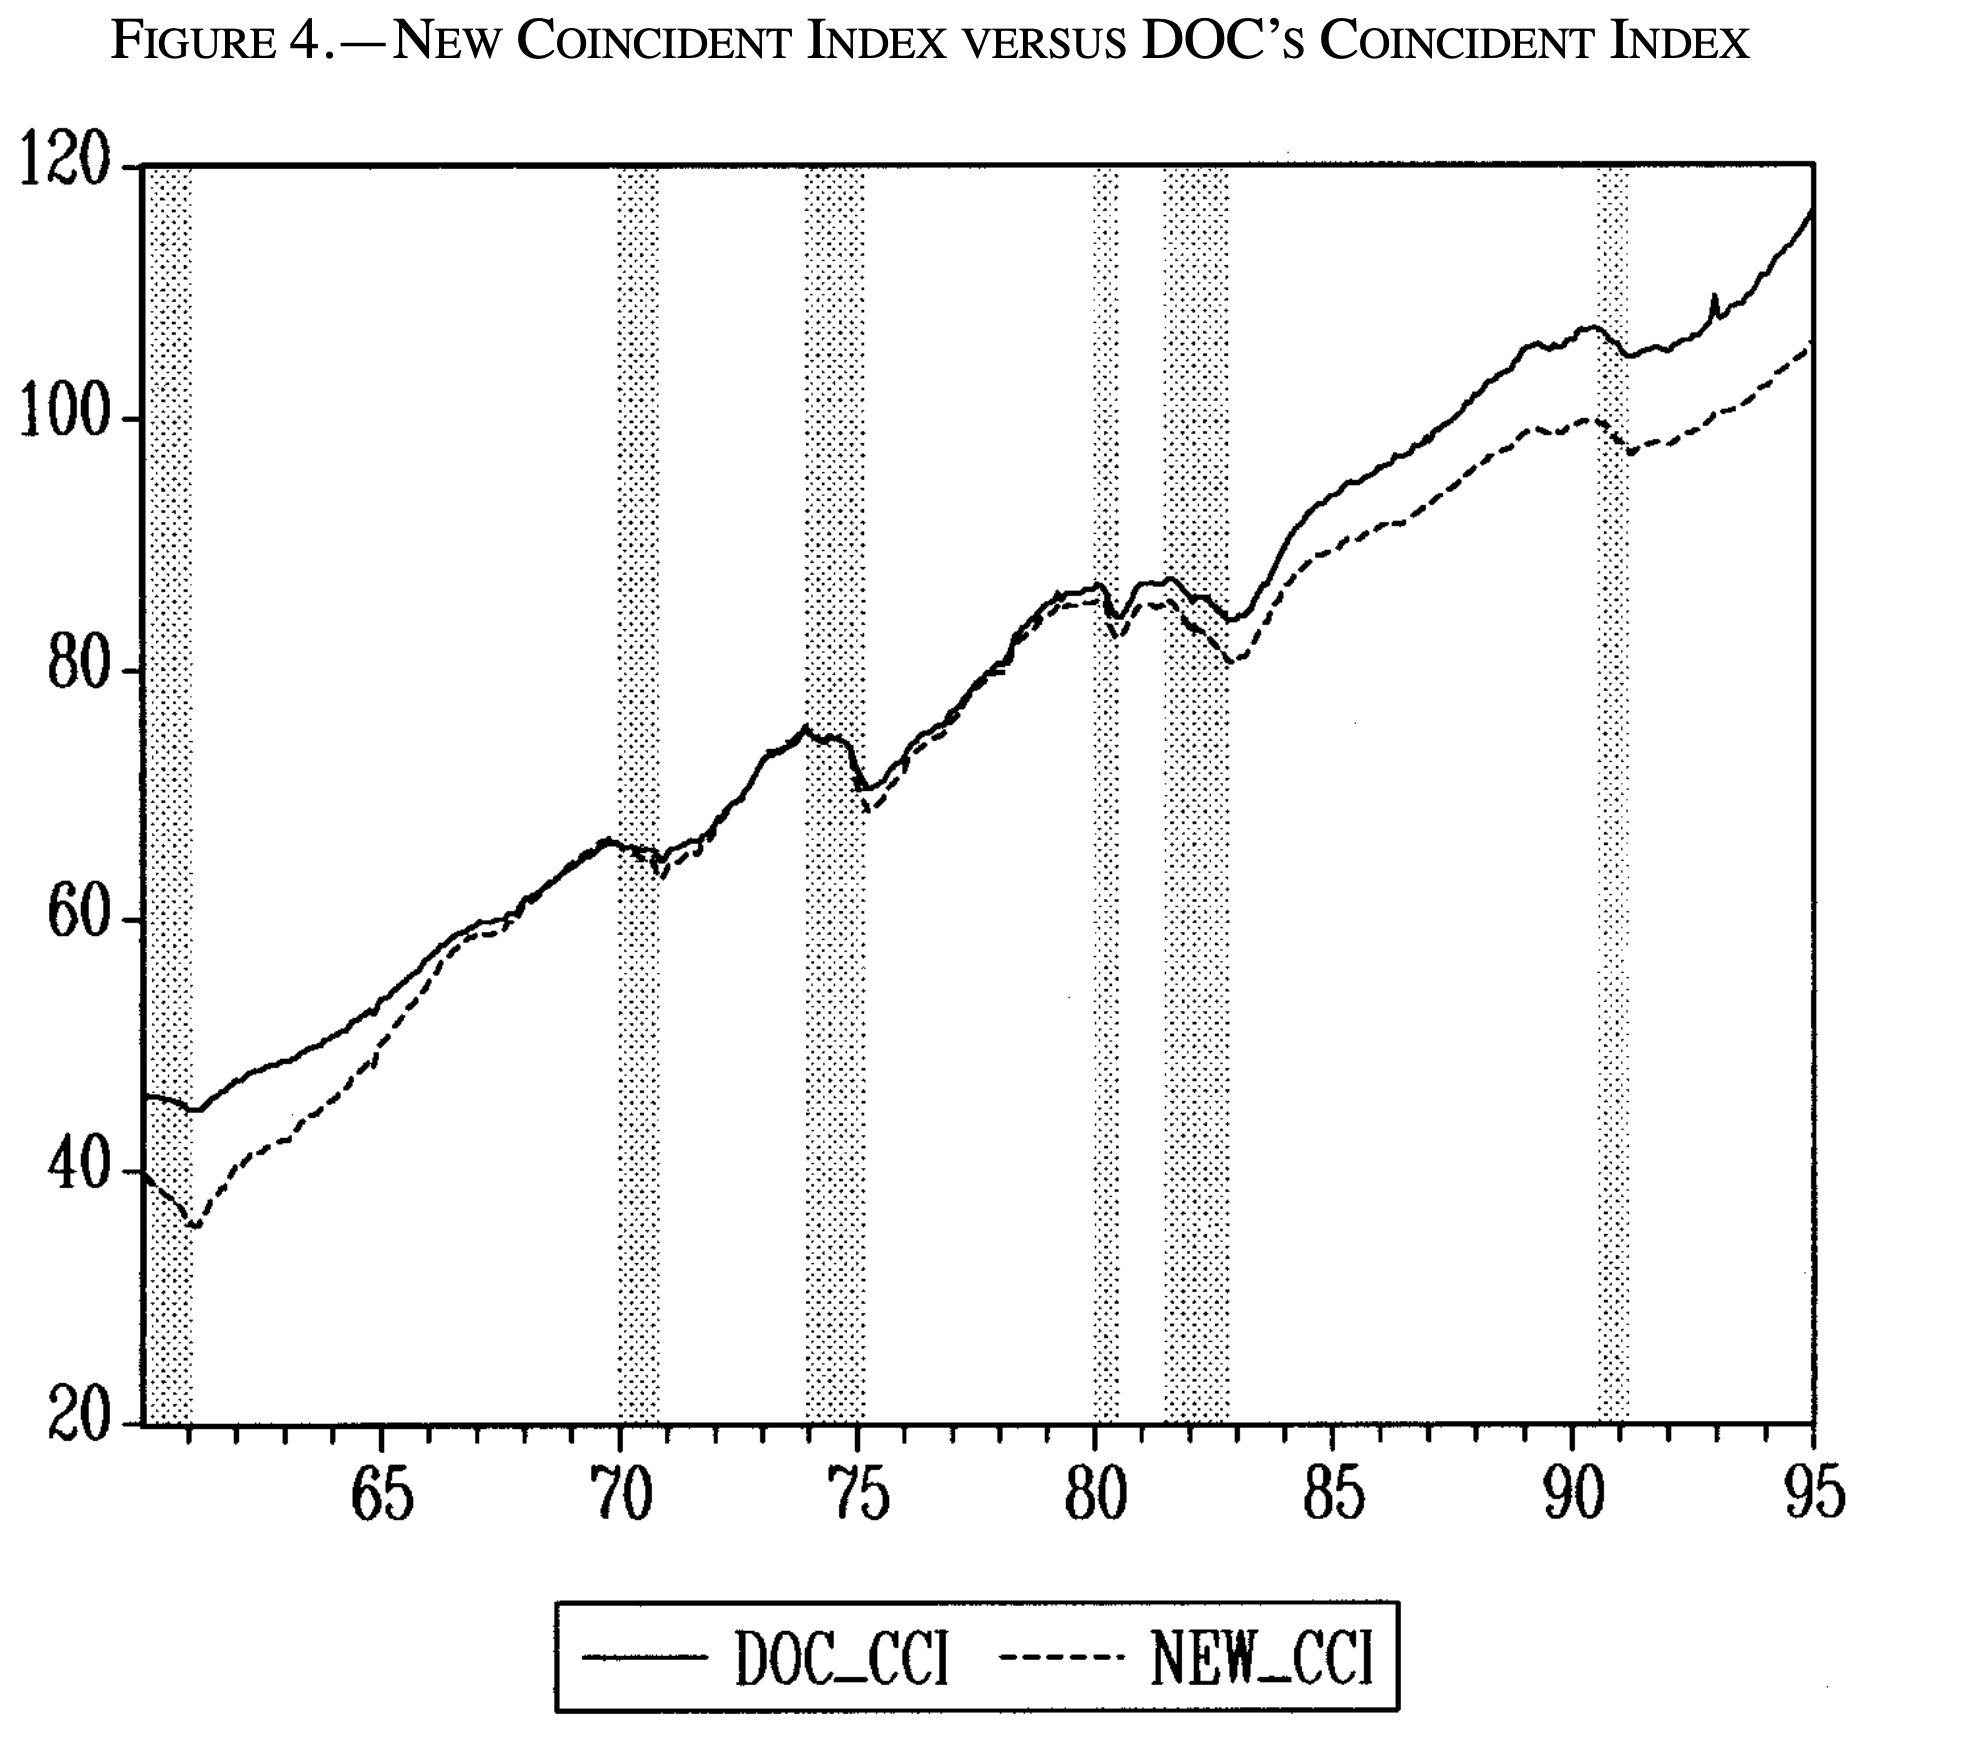
